# Loading

In [ ]:
!pip install networkx

In [ ]:
!pip install pyro-ppl
!pip install torch
!pip install torch-geometric

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

from networkx.generators.random_graphs import random_powerlaw_tree
from networkx.linalg.graphmatrix import adjacency_matrix

# GCN

## Env

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from networkx.generators.random_graphs import random_powerlaw_tree
from networkx.linalg.graphmatrix import adjacency_matrix


class kgEnv():
    def __init__(self, n_nodes):
        # generate a tree
        G = random_powerlaw_tree(n_nodes, gamma=np.random.rand() * 2 + 2, tries=100000)
        A = adjacency_matrix(G).todense()
        A = np.array(A)

        # random change the direction
        for i in range(n_nodes):
            for j in range(i, n_nodes):
                if A[i, j] == 1:
                    if np.random.rand() < 0.5:
                        A[i, j] = 0
                    else:
                        A[j, i] = 0

        # save this but not used: the original tree
        self.origin_A = A.copy()

        # save the layout for further use
        G = nx.convert_matrix.from_numpy_array(A, create_using=nx.DiGraph())
        self.origin_layout = nx.planar_layout(G)

        # randomly generate the probability
        prob = np.random.rand(n_nodes)
        self.prob = prob

        # save the graph
        self.n_nodes = n_nodes
        self.nodes = list(range(n_nodes))
        self.A = A.copy()

    def get_adj(self):
        return self.nodes.copy(), self.A.copy()

    def remove_node(self, node):
        if node not in self.nodes:
            return [], -1, None

        # correct or not
        correct = False
        if np.random.rand() <= self.prob[node]:
            correct = True

        # initialize
        tmp1 = [node]
        tmp2 = []
        rm_list = set()
        # if not correct
        if not correct:
            while len(tmp1) > 0:
                for n in tmp1:
                    tmp2 = tmp2 + list(np.where(self.A[n, :] == 1)[0])
                    self.A[n, :] = 0
                    self.A[:, n] = 0
                    rm_list.add(n)
                tmp1 = list(set(tmp2))
                tmp2 = []

        # if forward
        if correct:
            while len(tmp1) > 0:
                for n in tmp1:
                    tmp2 = tmp2 + list(np.where(self.A[:, n] == 1)[0])
                    self.A[n, :] = 0
                    self.A[:, n] = 0
                    rm_list.add(n)
                tmp1 = list(set(tmp2))
                tmp2 = []

        for n in rm_list:
            self.nodes.remove(n)
        return rm_list, (len(self.nodes) == 0) * 10, correct

    def reset_all(self):
        self.A = self.origin_A.copy()
        self.nodes = list(range(self.n_nodes))

    def plot_graph(self, plot_type=0):
        # plot_type = 0/1: origin graph, current graph
        if plot_type == 0:
            i_edge, o_edge = np.where(self.origin_A == 1)
            labels = {i: '{}: {:.2f}'.format(i, self.prob[i]) for i in range(self.n_nodes)}
        if plot_type == 1:
            i_edge, o_edge = np.where(self.A == 1)

        # create a graph
        df = pd.DataFrame({'from': i_edge, 'to': o_edge})
        G = nx.from_pandas_edgelist(df, 'from', 'to', create_using=nx.DiGraph())
        for n in self.nodes:
            G.add_node(n)

        # plot in a planar method
        if plot_type < 0.5:
            nx.draw(G, pos=self.origin_layout, labels=labels,
                    with_labels=True, node_size=250, arrows=True,
                    node_color='whitesmoke', font_color='red')
        else:
            nx.draw(G, with_labels=True, node_size=250, alpha=0.8,
                    arrows=True, pos=self.origin_layout)
        plt.title("Graph: " + str(plot_type))
        plt.show()




In [ ]:
def bfs(input):
    val_node=input[0].copy()
    graph = input[1].copy()
    n_nodes = len(graph)
    m = int(n_nodes/2)
    dis_mat=[]
    for n_node in range(n_nodes):
        new_mat = np.zeros([n_nodes])
        matrix = [graph.copy(),graph.T.copy()]
        for idx,mat in enumerate(matrix):
            bfs = []
            tmp1_node = [n_node]
            tmp2_node = []
            # begin
            while len(tmp1_node) + len(tmp2_node) > 0:
                # for each parent
                for parent_node in tmp1_node:
                    tmp = [parent_node, []]
                    # for each child, row
                    for child_node, child_weight in enumerate(mat[parent_node, :]):
                        if child_weight > 0:
                            # add current node info
                            tmp[1].append(child_node)
                            # add children to tmp2
                            tmp2_node.append(child_node)
                            # remove this edge
                            mat[parent_node, child_node] = 0
                  
                
                    bfs.append(tmp.copy())
                # to next level
                tmp1_node = tmp2_node.copy()
                tmp2_node = []
          # print(bfs)
            keys=[]
            values=[]
            for i in range(len(bfs)):
                if bfs[i][0] not in keys:
                    keys.append(bfs[i][0])
                    values.append(bfs[i][1])
            bfs_dict=dict(zip(keys, values)) 
          # print(bfs_dict)
            if n_node in val_node:
                if idx== 0:
                  new_mat[0]=1
                  new_mat[2]=len(bfs_dict[n_node])+1
                else:
                  new_mat[1]=1
                  new_mat[3]=len(bfs_dict[n_node])+1
            for i in range(m-2):
                adj_node = []
                queue = [n_node]
                if n_node in val_node:
                  adj_node.append(n_node)
                adj_node.extend(bfs_dict[n_node])
                for loop in range(i+1):
                    a = []
                    for q_node in queue:

                        a.extend(bfs_dict[q_node])
                        for node in bfs_dict[q_node]:
                            #print(node)
                            for b in bfs_dict[node]:
                              # print(b)
                                if b not in adj_node:
                                    adj_node.append(b)
                    queue=a.copy()
                
                    
              # print(adj_node)
              # print(len(adj_node))
                if idx == 0: 
                    new_mat[2*(i+2)] = len(adj_node)
                else:
                    new_mat[2*(i+2)+1] = len(adj_node)

            
        dis_mat.append(new_mat)
      
    diag_mat = np.zeros([n_nodes, n_nodes])
    for v_node in val_node:
        diag_mat[v_node,v_node] = 1

    Lap_mat = np.zeros([n_nodes, n_nodes])
    Lap_mat[range(n_nodes), range(n_nodes)] = np.sum(graph, 1)
    Lap_mat = Lap_mat - graph

              
    return dis_mat,diag_mat,Lap_mat

In [ ]:
env = kgEnv(12)
env.remove_node(6)

({6, 11}, 0, True)

In [ ]:
graph=env.get_adj()

In [ ]:
graph[1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [ ]:
dis,dia,lap = bfs(graph)

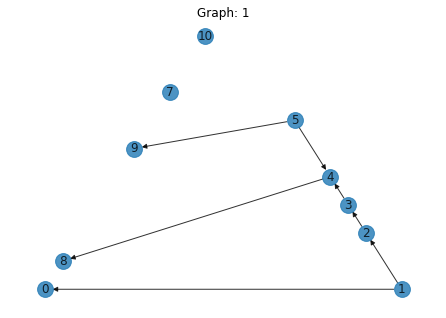

In [ ]:
env.plot_graph(1)

In [ ]:
dis

[array([1., 1., 1., 2., 1., 2., 1., 2., 1., 2., 1., 2.]),
 array([1., 1., 3., 1., 4., 1., 5., 1., 6., 1., 6., 1.]),
 array([1., 1., 2., 2., 3., 2., 4., 2., 4., 2., 4., 2.]),
 array([1., 1., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.]),
 array([1., 1., 2., 3., 2., 4., 2., 5., 2., 5., 2., 5.]),
 array([1., 1., 3., 1., 4., 1., 4., 1., 4., 1., 4., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 2., 1., 4., 1., 5., 1., 6., 1., 6.]),
 array([1., 1., 1., 2., 1., 2., 1., 2., 1., 2., 1., 2.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [ ]:
dia

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
lap

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  2.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [ ]:
k = np.zeros((3,12,12))
k[0,:,:] = dia
k[1,:,:] = lap

In [ ]:
env.remove_node(6)

({3, 4, 5, 6, 7, 8, 9, 10, 11}, 0, False)

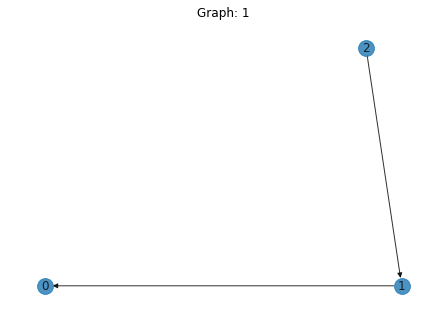

In [ ]:
env.plot_graph(1)

## GCN

In [ ]:
import torch_sparse
import torch_scatter
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [ ]:
dataset[0].x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
dataset[0].edge_index.shape

torch.Size([2, 10556])

In [ ]:
dataset[0].y

torch.Size([2708])

In [ ]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
from random import sample,seed,random
from torch_geometric.nn import GCNConv


n_nodes = 10
LR = 0.001      
GAMMA = 0.9    
N_STATES = n_nodes


class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()

    self.fc1 = nn.Linear(N_STATES, 50)
    self.fc1.weight.data.normal_(0, 0.1)
    self.out = nn.Linear(50, N_ACTIONS)
    self.out.weight.data.normal_(0, 0.1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    actions_value = self.out(x)
    m = nn.Sigmoid()
    return m(actions_value)


class DQN():
  def __init__(self):  # define DQN
    self.eval_net, self.target_net = Network(), Network()
    self.EPSILON = 0.5
    self.decay_e = 0.0004
    self.learn_step_counter = 0
    self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)  # optimization


  def predict(self,state):
    Q = self.eval_net.forward(state)
    Q = Q.tolist()
    Q = Q[0]
    return Q

  def select(self,Q):
    if np.random.uniform() < self.EPSILON:
        selectedAction = np.random.choice(list(np.where(np.array(Q) == max(Q))[0]), 1)[0]
    else:
        selectedAction = np.random.randint(0, N_ACTIONS)
    action = [0, 0, 0, 0, 0]
    action[selectedAction] = 1
    selectedQ = Q[selectedAction]
    return action,selectedQ

  def train(self,state,action,utility,next_state):
    # target parameter update
    if self.learn_step_counter % 50 == 0:
        self.target_net.load_state_dict(self.eval_net.state_dict())
    self.learn_step_counter += 1

    state = torch.unsqueeze(torch.FloatTensor(state), 0)
    next_state = torch.unsqueeze(torch.FloatTensor(next_state), 0)
    action = torch.unsqueeze(torch.FloatTensor(action), 0)
    index = torch.argmax(action)

    q_eval = self.eval_net(state)
    q = q_eval[0]
    q = q[index]

    # next
    if utility == -1 or utility == 0:
        nextQ = 0
    elif utility == 1:
        nextQ = 1
    else:
        nextQ = self.target_net(next_state).detach()
        nextQ,_= torch.max(nextQ, dim=1)

    q_target = utility + GAMMA * nextQ
    loss = (q_target - q)**2
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def update(self):
    self.EPSILON += self.decay_e


In [ ]:
def Navigator():
    dqnconHandler = DQN()
    plotHandler = Dplot(16)
    # init
    suc = 0
    ver = 100

    for turn in range(3001):
        # print
        if(turn % ver == 0):
            print("number of iterations:{t}, and the hit rate is:{h}".format(t=turn, h=suc/ver))
            # reset
            suc = 0

        # generate environment
        actionHandler = MineField()
        actionHandler.genrateMines()
        actionHandler.generateCar()
        actionHandler.generateAim()

        # plot
        if (turn % ver == 0):
            plotHandler.newPlot()
            plotHandler.initialPlot(actionHandler.TMineArray,actionHandler.path,actionHandler.aimPos)

        utility = 0.5
        while len(actionHandler.path[0]) < actionHandler.maxAction and utility > 0 and utility != 1:
            state = actionHandler.getSensor() + actionHandler.getState()
            allQ = dqnconHandler.predict(state)

            #select valid action
            action = [0,0,0,0,0]
            for i in range(5):
                action[i] = 1
                if actionHandler.testMovement(action):
                    allQ[i] = -1
                action[i] = 0

            # select action
            movement,selectedQ = dqnconHandler.select(allQ)

            #train
            if selectedQ == -1:
                utility = 0
                dqnconHandler.train(state, [1,1,1,1,1], utility,  state)
            else:
                pre_utility, utility = actionHandler.getUtility(movement)

                # plot
                if (turn % ver == 0):
                    plotHandler.moveOneStep(actionHandler.path)

                # set utility
                if utility == 1:
                    suc = suc + 1

                # next state
                nextState = actionHandler.getSensor() + actionHandler.getState()
                # train
                dqnconHandler.train(state, movement, utility, nextState)

        # UPDATE
        dqnconHandler.update()
        del actionHandler

    return 1

res = Navigator()

In [ ]:

#数据集加载
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

#网络定义
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

#网络训练
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

#测试
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

In [ ]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: 增加自连接到邻接矩阵
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: 对节点的特征矩阵进行线性变换
        x = self.lin(x)

        # Step 3-5: Start propagating messages.
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j, edge_index, size):
        # x_j has shape [E, out_channels]

        # Step 3: Normalize node features.
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Step 5: Return new node embeddings.
        return aggr_out

# MCMC Sampling

In [ ]:
import numpy as np
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as pyrodist
from tqdm import tqdm

In [ ]:
def model(y, pri_person_u, pri_person_v, pri_item_u, pri_item_v):
    # 1. set the prior
    exam_pri = pyrodist.Normal(pri_person_u, pri_person_v)
    item_pri = pyrodist.Normal(pri_item_u, pri_item_v)

    # 2. Sample a value from the weight distributoin
    exam = pyro.sample("exam", exam_pri)
    item = pyro.sample("item", item_pri)
    p = 1. / (1. + torch.exp(- exam + item))

    # 3. Now use a that value to define our scale (remember our scale gives us values
    my_dist = pyrodist.Bernoulli(p)

    # 4. For each of the observations, let's draw a sample from our distribution.
    measurement = pyro.sample('obs', my_dist, obs=y)


In [ ]:
def getPost(y, pri_person_u, pri_person_v, pri_item_u, pri_item_v):
  # 1. Clear storage of named parameters
  pyro.clear_param_store()

  # 2. Define the MCMC kernel function
  my_kernel = pyro.infer.NUTS(model)

  # 3. Define the MCMC algorithm
  my_mcmc = pyro.infer.MCMC(my_kernel, num_samples=8000, warmup_steps=2000, 
                      num_chains=1, disable_progbar=1)

  y = torch.tensor(y, dtype=torch.float32, requires_grad=False)
  p_m = torch.tensor(pri_person_u, dtype=torch.float32, requires_grad=False)
  p_v = torch.tensor(pri_person_v, dtype=torch.float32, requires_grad=False)
  i_m = torch.tensor(pri_item_u, dtype=torch.float32, requires_grad=False)
  i_v = torch.tensor(pri_item_v, dtype=torch.float32, requires_grad=False)

  # 4. Run the algorithm, send our observations
  my_mcmc.run(y, p_m, p_v, i_m, i_v)

  # update
  pos_person_mu = my_mcmc.get_samples()['exam'].mean(axis=0)
  pos_person_std = my_mcmc.get_samples()['exam'].std(axis=0)
  pos_item_mu = my_mcmc.get_samples()['item'].mean(axis=0)
  pos_item_std = my_mcmc.get_samples()['item'].std(axis=0)

  return pos_person_mu, pos_person_std, pos_item_mu, pos_item_std

# NN To Train a MCMC Predictor

## Data Gen

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd ./gdrive/MyDrive/EE209_COMP_ROB

In [ ]:
def genBtach(batch):
  y = np.random.randint(0, 2, batch)
  p_m = np.random.randn(batch)
  p_v = np.exp(np.random.randn(batch)-2)
  i_m = np.random.randn(batch)
  i_v = np.exp(np.random.randn(batch)-2)

  data = np.zeros([batch, 8])
  target = np.zeros([batch, 4])
  
  for i in tqdm(range(batch)):
    a,b,c,d = getPost(y[i], p_m[i], p_v[i], i_m[i], i_v[i])
    data[i, 0] = p_m[i]
    data[i, 1] = p_v[i]
    data[i, 2] = i_m[i]
    data[i, 3] = i_v[i]
    data[i, 4] = y[i]
    data[i, 5] = 1 - y[i]
    p = 1.0 / (1.0 + np.exp(- p_m[i] + i_m[i]))
    data[i, 6] = p
    data[i, 7] = 1-p

    target[i, 0] = a
    target[i, 1] = b
    target[i, 2] = c
    target[i, 3] = d
  
  return data, target

In [ ]:
#import pickle

#for i in range(20,40):
#  x,y = genBtach(500)
#  pickle.dump([x,y], open("save_"+str(i)+".p", "wb" ))

## train

In [ ]:
import pickle

xs = np.zeros([20000, 8])
ys = np.zeros([20000, 4])
for i in range(40):
  x,y = pickle.load(open("save_"+str(i)+".p", "rb" ))
  xs[i*500:(i+1)*500] = x
  ys[i*500:(i+1)*500] = y

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32))
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
      super().__init__()
      self.fc1 = nn.Linear(8, 20)
      self.fc2 = nn.Linear(20, 20)
      self.fc3 = nn.Linear(20, 10)
      self.fc4 = nn.Linear(10, 4)

    def forward(self, x):
      idendity = x
      x1 = torch.sigmoid(self.fc1(x))
      x2 = torch.sigmoid(self.fc2(x1))
      x3 = torch.sigmoid(self.fc3(x2))
      x4 = self.fc4(x3) + idendity[:,0:4]
      return x4

net = Net()

In [ ]:
import torch.optim as optim

my_loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

In [ ]:
for epoch in range(10000):  # loop over the dataset multiple times
  running_loss = 0.0
  for i, data in enumerate(train_dataloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = my_loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
  if epoch % 100 == 99:
    print('epoch %d, loss: %.5f'%(epoch+1, running_loss/len(train_dataloader)))
  running_loss = 0.0

print('Finished Training')

epoch 100, loss: 0.00128
epoch 200, loss: 0.00079
epoch 300, loss: 0.00069
epoch 400, loss: 0.00066
epoch 500, loss: 0.00065
epoch 600, loss: 0.00064
epoch 700, loss: 0.00063
epoch 800, loss: 0.00062
epoch 900, loss: 0.00062
epoch 1000, loss: 0.00061
epoch 1100, loss: 0.00061
epoch 1200, loss: 0.00061
epoch 1300, loss: 0.00061
epoch 1400, loss: 0.00060
epoch 1500, loss: 0.00061
epoch 1600, loss: 0.00060
epoch 1700, loss: 0.00060
epoch 1800, loss: 0.00060
epoch 1900, loss: 0.00060
epoch 2000, loss: 0.00060
epoch 2100, loss: 0.00060
epoch 2200, loss: 0.00059
epoch 2300, loss: 0.00059
epoch 2400, loss: 0.00059
epoch 2500, loss: 0.00059
epoch 2600, loss: 0.00059
epoch 2700, loss: 0.00059
epoch 2800, loss: 0.00059
epoch 2900, loss: 0.00059
epoch 3000, loss: 0.00059
epoch 3100, loss: 0.00059
epoch 3200, loss: 0.00058
epoch 3300, loss: 0.00058
epoch 3400, loss: 0.00058
epoch 3500, loss: 0.00058
epoch 3600, loss: 0.00058
epoch 3700, loss: 0.00058
epoch 3800, loss: 0.00058
epoch 3900, loss: 0.0

## Test

In [ ]:
net(torch.tensor(xs[[2],:], dtype=torch.float32))

# Reject Sampling

In [ ]:
x = [0.83141085, 0.20049269, 0.83141085, 0.10996936]

In [ ]:
getPost(0, x[0], x[1], x[2], x[3])

(tensor(0.8124), tensor(0.1979), tensor(0.8365), tensor(0.1100))

In [ ]:
getPost(1, x[0], x[1], x[2], x[3])

(tensor(0.8546), tensor(0.2011), tensor(0.8278), tensor(0.1112))

In [ ]:
p_m = torch.tensor(x[0], dtype=torch.float32, requires_grad=False)
p_s = torch.tensor(x[1], dtype=torch.float32, requires_grad=False)
i_m = torch.tensor(x[2], dtype=torch.float32, requires_grad=True)
i_s = torch.tensor(x[3], dtype=torch.float32, requires_grad=False)

p = 1/(1+torch.exp(-p_m+i_m))
q = 1 - p

norm = torch.distributions.normal.Normal(0, 1)
abi = p_m + p_s * norm.sample([1000000])
itm = i_m + i_s * norm.sample([1000000])

ps = 1/(1+torch.exp(-abi+itm))
qs = 1 - ps

u = torch.distributions.uniform.Uniform(0,1)
u1 = u.sample([1000000])
u2 = u.sample([1000000])

In [ ]:
abi[u1<ps].mean()

tensor(0.8509)

In [ ]:
abi[u1<ps].std()

tensor(0.1997)

In [ ]:
abi[u2<qs].mean()

tensor(0.8113)

In [ ]:
abi[u2<qs].std()

tensor(0.1992)

In [ ]:
for i in range(1000):
  p_m = torch.tensor(x[0], dtype=torch.float32, requires_grad=False)
  p_s = torch.tensor(x[1], dtype=torch.float32, requires_grad=False)
  i_m = torch.tensor(x[2], dtype=torch.float32, requires_grad=True)
  i_s = torch.tensor(x[3], dtype=torch.float32, requires_grad=False)

  p = 1/(1+torch.exp(-p_m+i_m))
  q = 1 - p

  norm = torch.distributions.normal.Normal(0, 1)
  abi = p_m + p_s * norm.sample([10000])
  itm = i_m + i_s * norm.sample([10000])

  ps = 1/(1+torch.exp(-abi+itm))
  qs = 1 - ps

  u = torch.distributions.uniform.Uniform(0,1)
  u1 = u.sample([10000])
  u2 = u.sample([10000])

  loss1 = p*(abi[u1<ps].std()) + q*(abi[u2<qs].std())
  #loss2 = p*(itm[u1<ps].std()) + q*(itm[u2<qs].std())

  loss = loss1

  loss.backward()

  x[2] -= i_m.grad.numpy()
  #x[3] += 10*i_s.grad.numpy()
  #x[3] = min(x[3],1)
  print(x)

[0.83141085, 0.14749269, 0.036463844617203665, 0.12996936]
[0.83141085, 0.14749269, 0.03638826781210149, 0.12996936]
[0.83141085, 0.14749269, 0.03684334438551808, 0.12996936]
[0.83141085, 0.14749269, 0.0366685298268137, 0.12996936]
[0.83141085, 0.14749269, 0.0368472932368902, 0.12996936]
[0.83141085, 0.14749269, 0.03690558507699528, 0.12996936]
[0.83141085, 0.14749269, 0.03700081526952339, 0.12996936]
[0.83141085, 0.14749269, 0.036667117443387486, 0.12996936]
[0.83141085, 0.14749269, 0.036611969133475884, 0.12996936]
[0.83141085, 0.14749269, 0.037087824648581534, 0.12996936]
[0.83141085, 0.14749269, 0.03777163887755954, 0.12996936]
[0.83141085, 0.14749269, 0.03805763700987221, 0.12996936]
[0.83141085, 0.14749269, 0.03849746690141977, 0.12996936]
[0.83141085, 0.14749269, 0.038461715745172785, 0.12996936]
[0.83141085, 0.14749269, 0.038851096445826204, 0.12996936]
[0.83141085, 0.14749269, 0.03916113987182392, 0.12996936]
[0.83141085, 0.14749269, 0.03878770801205313, 0.12996936]
[0.8314108

In [ ]:
i_s

tensor(0.1300, requires_grad=True)

In [ ]:
x[3] - i_s.grad.numpy()

AttributeError: ignored

In [ ]:
i_s.grad

In [ ]:
itm[u<ps/qs].std()

tensor(0.1273)

In [ ]:
getPost(0, xs[2,0],xs[2,1],xs[2,2],xs[2,3])

(tensor(0.8172), tensor(0.1410), tensor(0.0657), tensor(0.1297))

In [ ]:
1/0.12

8.333333333333334

In [ ]:
1/0.11

9.090909090909092